In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## goal: we want to find patterns in train.csv that help us predict whether the passengers in test.csv survived.

In [2]:
# read all datasets
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
gender_data = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
train_data.head()
# gender_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# add family_size feature
train_data["family_size"] = train_data["SibSp"] + train_data["Parch"]
test_data["family_size"] = test_data["SibSp"] + test_data["Parch"]

# count missing vals for both train and test
count_missing_vals = train_data.isnull().sum()
print(count_missing_vals)
print("\n\n")
count_missing_vals = test_data.isnull().sum()
print(count_missing_vals)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
family_size      0
dtype: int64



PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
family_size      0
dtype: int64


In [4]:
# fill missing age values with mean for both train and test datasets
train_mean_age = round(train_data["Age"].mean())
train_data.fillna({"Age": train_mean_age}, inplace=True)

test_mean_age = round(test_data["Age"].mean())
test_data.fillna({"Age": test_mean_age}, inplace=True)

# change Sex (Categorical) to Numerical for train and test
pd.set_option('future.no_silent_downcasting', True) # need this or else Downcasting behavior
train_data.replace({"Sex": {"female": 1, "male": 0}}, inplace=True)
test_data.replace({"Sex": {"female": 1, "male": 0}}, inplace=True)
train_data["Sex"] = train_data["Sex"].astype(int)
test_data["Sex"] = test_data["Sex"].astype(int)

In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,family_size
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,29.758889,0.523008,0.381594,32.204208,0.904602
std,257.353842,0.486592,0.836071,0.477990,13.002570,1.102743,0.806057,49.693429,1.613459
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,0.000000,3.000000,0.000000,30.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,10.000000


In [6]:
# filter train_data for numeric values to conduct numeric data analysis
num_train_data = train_data.select_dtypes(include=['number'])
train_corr_matrix = num_train_data.corr()
train_corr_matrix

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,family_size
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.033019,-0.057527,-0.001652,0.012658,-0.040143
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.070657,-0.035322,0.081629,0.257307,0.016639
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.329727,0.083081,0.018443,-0.549500,0.065997
Sex,-0.042939,0.543351,-0.131900,1.000000,-0.084660,0.114631,0.245489,0.182333,0.200988
Age,0.033019,-0.070657,-0.329727,-0.084660,1.000000,-0.232440,-0.180330,0.090632,-0.248954
SibSp,-0.057527,-0.035322,0.083081,0.114631,-0.232440,1.000000,0.414838,0.159651,0.890712
Parch,-0.001652,0.081629,0.018443,0.245489,-0.180330,0.414838,1.000000,0.216225,0.783111
Fare,0.012658,0.257307,-0.549500,0.182333,0.090632,0.159651,0.216225,1.000000,0.217138
family_size,-0.040143,0.016639,0.065997,0.200988,-0.248954,0.890712,0.783111,0.217138,1.000000


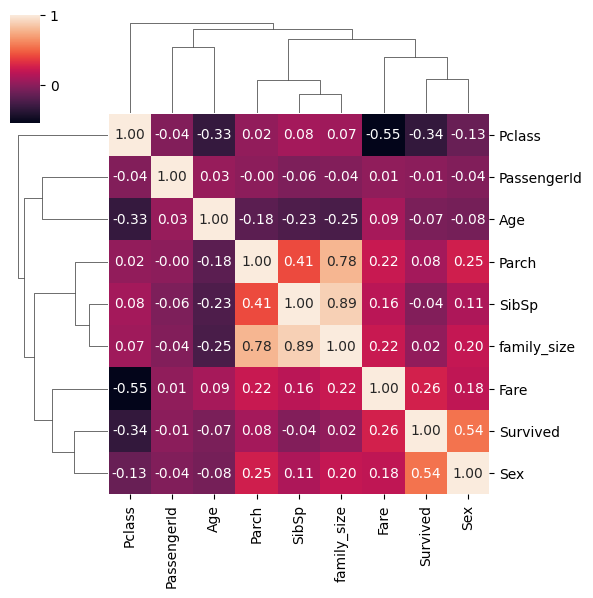

In [7]:
# plot clustermap to see linkages and correlation vals
mask = np.triu(np.ones_like(train_corr_matrix))
sns.clustermap(train_corr_matrix,
               annot=True,
              fmt='.2f',
              figsize=(6,6))

In [8]:
# begin ML trying with SVM Classification first
from sklearn import svm

y = train_data["Survived"]
features = ["Pclass", "Sex", "family_size", "Age"]

X = pd.get_dummies(train_data[features])
# np.any(np.isnan(X))
# np.isfinite(X.all())
# Check for infinite values
# print(np.any(~np.isfinite(X)))  # Should return False

X_test = pd.get_dummies(test_data[features])

# np.any(np.isnan(X_test))
# np.isfinite(X_test.all())
# Check for infinite values
# print(np.any(~np.isfinite(X_test)))  # Should return False

# misvals = X_test.isnull().sum()
# print(misvals)

clf = svm.SVC(C=1.0, kernel='linear', random_state=42)
clf.fit(X, y)

predictions = clf.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("submission written!")

submission written!


In [9]:
# now try
# adding different features
# scaling all features
# using different kernels
# grid search for best hyperparameters
# try random forest and/or XGBoost

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

y = train_data["Survived"]
features = ["Pclass", "Sex", "family_size", "Age"]

X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])


kf = KFold(n_splits=5, shuffle=True, random_state=1) # 83->85% accuracy
kf.get_n_splits(X)

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    # print(f"Fold: {i}")
    # print(f"Train index={train_index}")
    # print(f"Test index={test_index}")

    # use iloc or else KeyError
    clf = svm.SVC(C=1.0, kernel='linear', random_state=42)
    clf.fit(X.iloc[train_index], y.iloc[train_index]) # train on subset
    
    y_pred = clf.predict(X.iloc[test_index]) # validate 
    accuracy = accuracy_score(y.iloc[test_index], y_pred)

    print(f"Fold: {i}, accuracy: {accuracy}")


Fold: 0, accuracy: 0.776536312849162
Fold: 1, accuracy: 0.7247191011235955
Fold: 2, accuracy: 0.797752808988764
Fold: 3, accuracy: 0.8314606741573034
Fold: 4, accuracy: 0.8033707865168539


In [11]:
# from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score
# # Access the training and validation indices of splits
# kfold_accuracy = {}
# kfold_precision = {}
# kfold_f = {}
# kfold_recall = {}

# train_data["family_size"] = train_data["SibSp"] + train_data["Parch"]
# test_data["family_size"] = test_data["SibSp"] + test_data["Parch"]

# y = train_data["Survived"]
# features = ["Pclass", "Sex", "family_size"]

# X = pd.get_dummies(train_data[features])
# X_test = pd.get_dummies(test_data[features])

# kf = KFold(n_splits=5, shuffle=True, random_state=1)
# splits = kf.split(X)

# for i, (train_index, val_index) in enumerate(splits):
#   print("Split n°: ", i)
#   # Setup the training and validation data
#   X_train, y_train = X.iloc[train_index], y.iloc[train_index]
#   # print("training:", train_index, "validations:", val_index)
#   X_val,y_val= X.iloc[val_index], y.iloc[val_index]

#   SVM = svm.SVC(C=1.0, kernel='linear', random_state=1111, probability=True) ### the base estimator

#   SVM.fit(X_train, y_train)

#   # predict the labels on validation dataset
#   predictions = SVM.predict(X_val)

#   # Use accuracy_score function to get the accuracy
#   kfold_accuracy[i] = accuracy_score(y_val, predictions)
#   kfold_precision[i] = precision_score(y_val, predictions)
#   kfold_f[i] = f1_score(y_val,predictions)
#   kfold_recall[i] = recall_score(y_val,predictions)

In [12]:
# # print dicts
# for k, v in kfold_accuracy.items():
#     print(f"Fold: {k}")
#     print(f"Accuracy: {kfold_accuracy[i]}")
#     print(f"Precision: {kfold_precision[i]}")
#     print(f"F1 Score: {kfold_f[i]}")
#     print(f"Recall: {kfold_recall[i]}")
#     print("\n")

In [13]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cm = confusion_matrix(y_val, predictions, labels=SVM.classes_)
# display = ConfusionMatrixDisplay(cm)
# display.plot()